In [1]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

#from konlpy.tag import Kkma

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
USE_CUDA = torch.cuda.is_available()
#USE_CUDA = False
GPU_ID = 2

# 1. Preprocess Dataset

In [3]:
SOS_IDX = 0
EOS_IDX = 1

In [4]:
class Data:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_IDX: "<s>", EOS_IDX: "</s>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
TOY_FILENAME = 'dataset/toy/data'

In [6]:
def makeToyData(name, size):
    MAX_LEN = 10
    MAX_RANGE = 50

    print("Generating toy data...")
    
    ROOT = 'dataset/toy'
    
    if not os.path.exists(ROOT):
        os.mkdir(ROOT)

    # generate data file
    data_path = os.path.join(ROOT, name)
    with open(data_path, 'w') as fout:
        for _ in range(size):
            length = random.randint(1, MAX_LEN)
            seq = []
            for _ in range(length):
                seq.append(str(random.randint(0, MAX_RANGE)))
            fout.write("\t".join([" ".join(seq), " ".join(reversed(seq))]))
            fout.write('\n')

    # generate vocabulary
    src_vocab = os.path.join(ROOT, name + '_vocab.source')
    with open(src_vocab, 'w') as fout:
        fout.write("\n".join([str(i) for i in range(MAX_RANGE)]))
    tgt_vocab = os.path.join(ROOT, name + '_vocab.target')
    shutil.copy(src_vocab, tgt_vocab)
    
    print("Success!")

In [7]:
if not os.path.exists(TOY_FILENAME):
    makeToyData('data', 12000)

In [8]:
def normalizeString(s):
    #s = s.lower().strip()
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
def readData(fileName=TOY_FILENAME, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(fileName, 'r', encoding='utf-8').readlines()

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l[:-1].split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_data = Data()
        output_data = Data()
    else:
        input_data = Data()
        output_data = Data()

    print("Success!")
    
    return input_data, output_data, pairs

In [10]:
def prepareData(fileName=TOY_FILENAME, reverse=False):
    input_data, output_data, pairs = readData()
    print("Read %s sentence pairs" % len(pairs))
    #pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_data.addSentence(pair[0])
        output_data.addSentence(pair[1])
    print("Counted words :")
    print("- Input data  :", input_data.n_words)
    print("- Output data :", output_data.n_words)
    
    return input_data, output_data, pairs

In [11]:
input_data, output_data, pairs = prepareData()
random.choice(pairs)

Reading lines...
Success!
Read 12000 sentence pairs
Trimmed to 12000 sentence pairs
Counting words...
Counted words :
- Input data  : 53
- Output data : 53


['15 34 22 33', '33 22 34 15']

In [12]:
train_data = [d for d in pairs[:10000]]
test_data = [d for d in pairs[:1000]]
dev_data = [d for d in pairs[:1000]]

In [13]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] for word in sentence.split(' ')]

In [14]:
def variableFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    indexes.append(EOS_IDX)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA:
        return result.cuda(GPU_ID)
    else:
        return result

In [15]:
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_data, pair[0])
    target_variable = variableFromSentence(output_data, pair[1])
    return (input_variable, target_variable)

# 3. Define Model

In [16]:
INPUT_SIZE = input_data.n_words  # Num of Words
HIDDEN_SIZE = 50  # Embedding Dimension
OUTPUT_SIZE = output_data.n_words
MAX_LENGTH = 10 + 1

In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [18]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [19]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        #print(ei, input_variable[ei], encoder_output.size())
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [20]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [21]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [22]:
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [23]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [35]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_data, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))  # SOS
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_IDX:
            decoded_words.append('</s>')
            break
        else:
            decoded_words.append(output_data.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    return decoded_words

In [36]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [51]:
NUM_EPOCH = 50000

In [52]:
encoder = EncoderRNN(INPUT_SIZE, HIDDEN_SIZE)
decoder = DecoderRNN(HIDDEN_SIZE, OUTPUT_SIZE)
if USE_CUDA:
    encoder.cuda(GPU_ID)
    decoder.cuda(GPU_ID)

0m 15s (- 13m 3s) (1000 2%) 2.5085
0m 28s (- 11m 23s) (2000 4%) 2.4994
0m 42s (- 10m 58s) (3000 6%) 2.4536
0m 55s (- 10m 36s) (4000 8%) 2.3512
1m 9s (- 10m 26s) (5000 10%) 2.1842
1m 23s (- 10m 14s) (6000 12%) 1.9580
1m 38s (- 10m 4s) (7000 14%) 1.8168
1m 53s (- 9m 57s) (8000 16%) 1.7274
2m 8s (- 9m 47s) (9000 18%) 1.6556
2m 23s (- 9m 32s) (10000 20%) 1.6184
2m 37s (- 9m 19s) (11000 22%) 1.5307
2m 52s (- 9m 5s) (12000 24%) 1.4109
3m 7s (- 8m 53s) (13000 26%) 1.3754
3m 22s (- 8m 40s) (14000 28%) 1.3475
3m 37s (- 8m 26s) (15000 30%) 1.3406
3m 52s (- 8m 14s) (16000 32%) 1.3167
4m 7s (- 8m 1s) (17000 34%) 1.2732
4m 23s (- 7m 48s) (18000 36%) 1.2399
4m 38s (- 7m 34s) (19000 38%) 1.2136
4m 52s (- 7m 19s) (20000 40%) 1.2316
5m 7s (- 7m 4s) (21000 42%) 1.1929
5m 21s (- 6m 49s) (22000 44%) 1.1567
5m 37s (- 6m 35s) (23000 46%) 1.2019
5m 52s (- 6m 21s) (24000 48%) 1.1638
6m 7s (- 6m 7s) (25000 50%) 1.1674
6m 23s (- 5m 53s) (26000 52%) 1.0873
6m 39s (- 5m 40s) (27000 54%) 1.1164
6m 54s (- 5m 25s) (

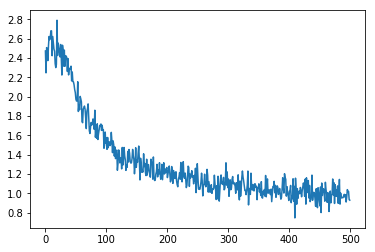

In [53]:
trainIters(encoder, decoder, NUM_EPOCH, print_every=1000)

In [54]:
evaluateRandomly(encoder, decoder)

> 50 14 13 28 3 1 42 18
= 18 42 1 3 28 13 14 50
< 18 42 3 50 13 50 28 3 </s>

> 24 22 26 39 48 23 4
= 4 23 48 39 26 22 24
< 4 48 39 26 26 </s>

> 16 13 29 49 5 1 36 13 44 43
= 43 44 13 36 1 5 49 29 13 16
< 44 43 13 5 36 29 5 13 29 </s>

> 47 47 46 12 11 26 30 35
= 35 30 26 11 12 46 47 47
< 35 26 11 30 11 47 12 </s>

> 31 4 9 14 23 1 45 10 38
= 38 10 45 1 23 14 9 4 31
< 38 10 4 31 9 1 14 23 </s>

> 19 48 37 12 25 13
= 13 25 12 37 48 19
< 13 25 12 48 19 48 37 </s>

> 3 5
= 5 3
< 5 3 </s>

> 26 40 15 5 42 33 20 24
= 24 20 33 42 5 15 40 26
< 24 20 23 5 42 26 42 </s>

> 32 33 35 49 23 44 2
= 2 44 23 49 35 33 32
< 2 44 23 35 35 33 </s>

> 8
= 8
< 8 </s>

